In [8]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt     
import matplotlib

matplotlib.rcParams['figure.figsize'] = [20, 10]

In [2]:
# Import Data Frame
LOG_NUM = 1001
PATH_TO_DF = r"C:\Users\lukas\OneDrive\Universität\Mathematik\Bachelorarbeit\log_dir\log_{}\SIMULATION_SUMMARY\simulation_summary_log_{}.pkl".format(LOG_NUM, LOG_NUM)
df = pd.read_pickle(PATH_TO_DF)


In [3]:
# Inspect the simulation results
print(df.tail())
print(df.info())

      agent_choice_of_x1  agent_final_cash_balance  \
9995              11.585                  8.772094   
9996              11.745                 16.436985   
9997              11.635                 10.811848   
9998              11.725                 13.135442   
9999              11.620                 14.366165   

      cumulative_liquidity_costs episode greedy  \
9995                   -0.551036    9995      0   
9996                   -1.035870    9996      0   
9997                   -0.680033    9997      0   
9998                   -0.834470    9998      1   
9999                   -0.887962    9999      0   

                      initial_state  optimal_choice_of_x1  \
9995  [[5.0], [10.0], [1.0], [0.0]]                   2.5   
9996  [[5.0], [10.0], [1.0], [0.0]]                   2.5   
9997  [[5.0], [10.0], [1.0], [0.0]]                   2.5   
9998  [[5.0], [10.0], [1.0], [0.0]]                   2.5   
9999  [[5.0], [10.0], [1.0], [0.0]]                   2.5   

 

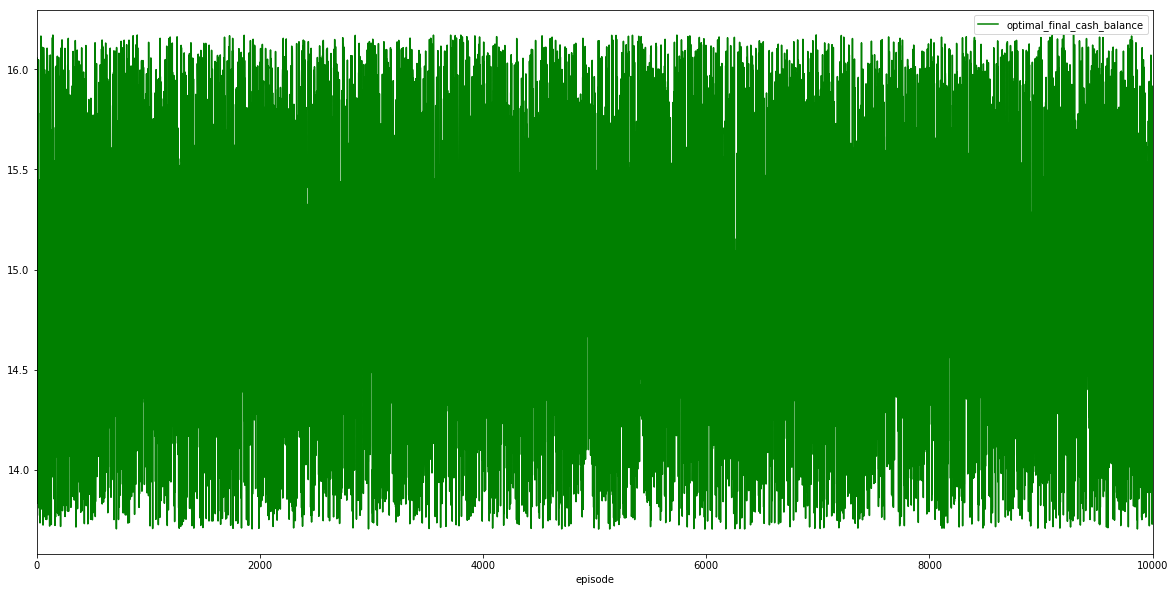

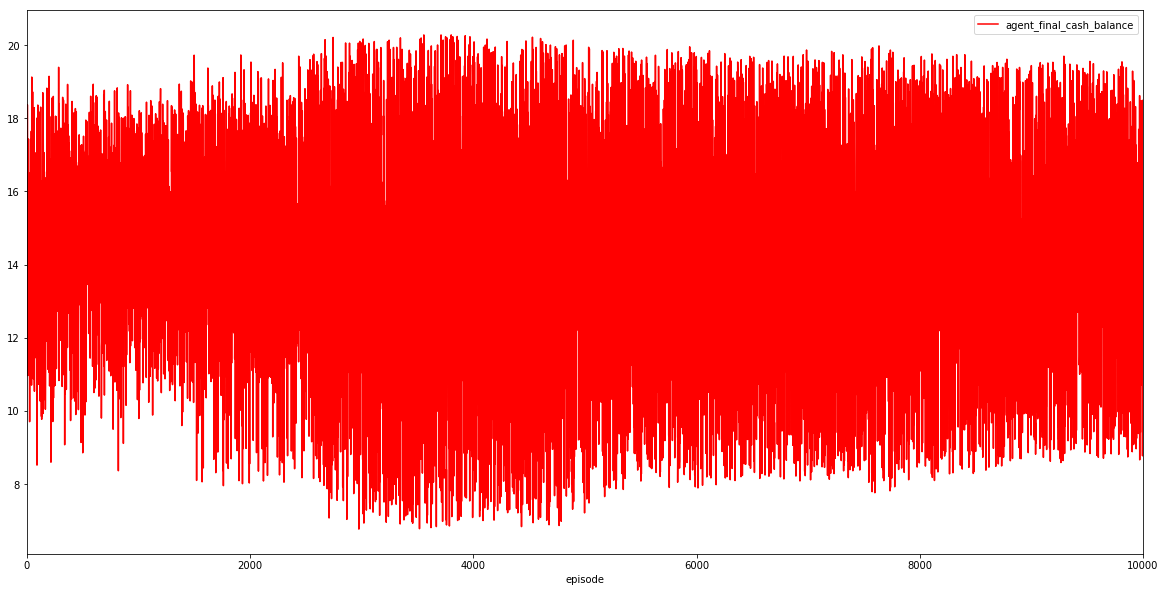

In [12]:
# Plot results with greedy
df.plot(x="episode", y="optimal_final_cash_balance", c="g")
df.plot(x="episode", y="agent_final_cash_balance", c="r")
plt.show()

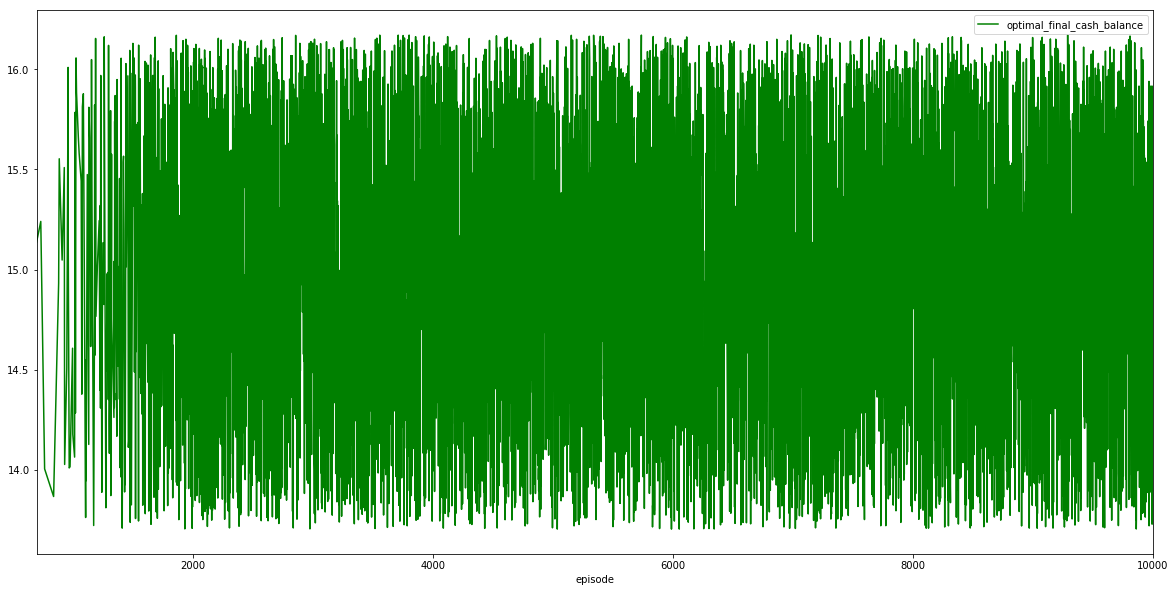

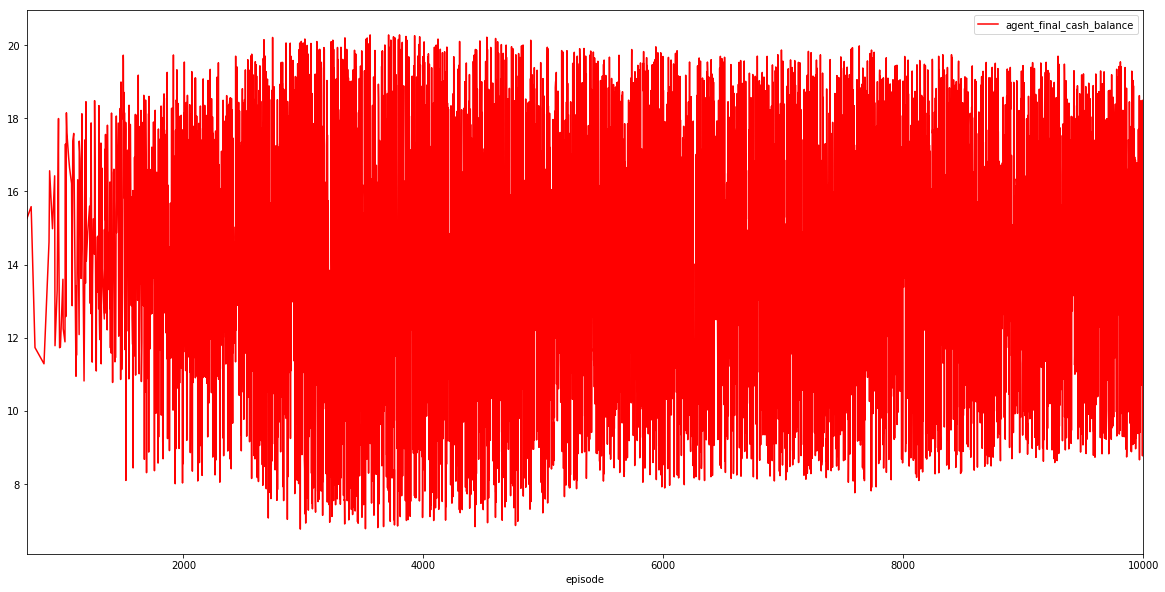

In [15]:
# Filter greedy results and plot again
df_wo_greedy = df[df["greedy"]==0]

# Plot results wo greedy
df_wo_greedy.plot(x="episode", y="optimal_final_cash_balance", c="g")
df_wo_greedy.plot(x="episode", y="agent_final_cash_balance", c="r")
plt.show()

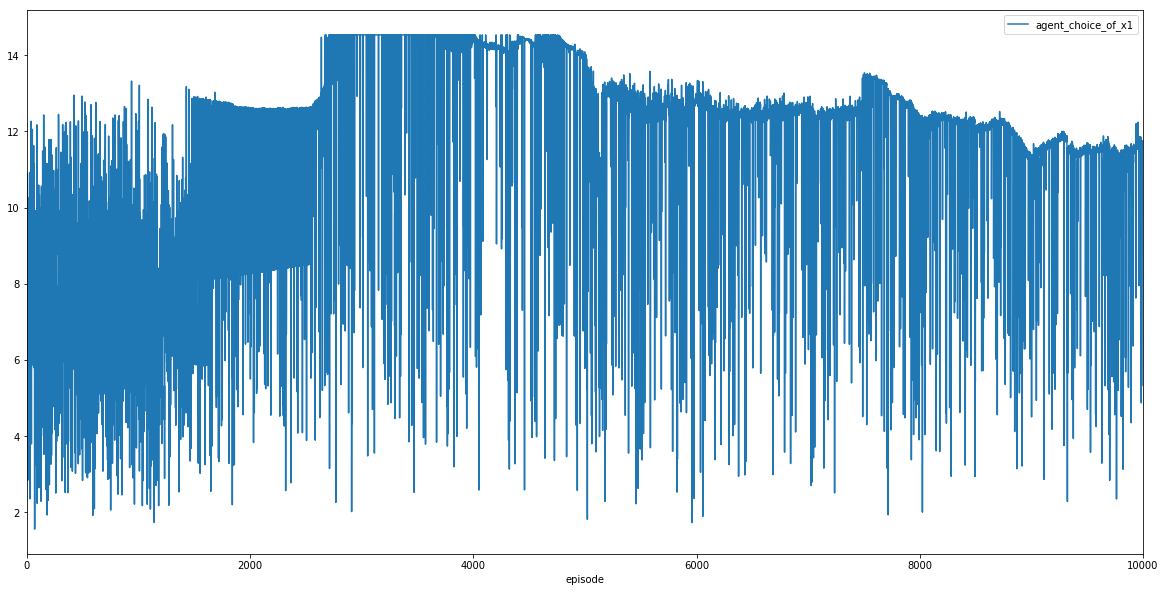

In [13]:
# Agent choice with greedy 

df.plot(x="episode", y="agent_choice_of_x1")

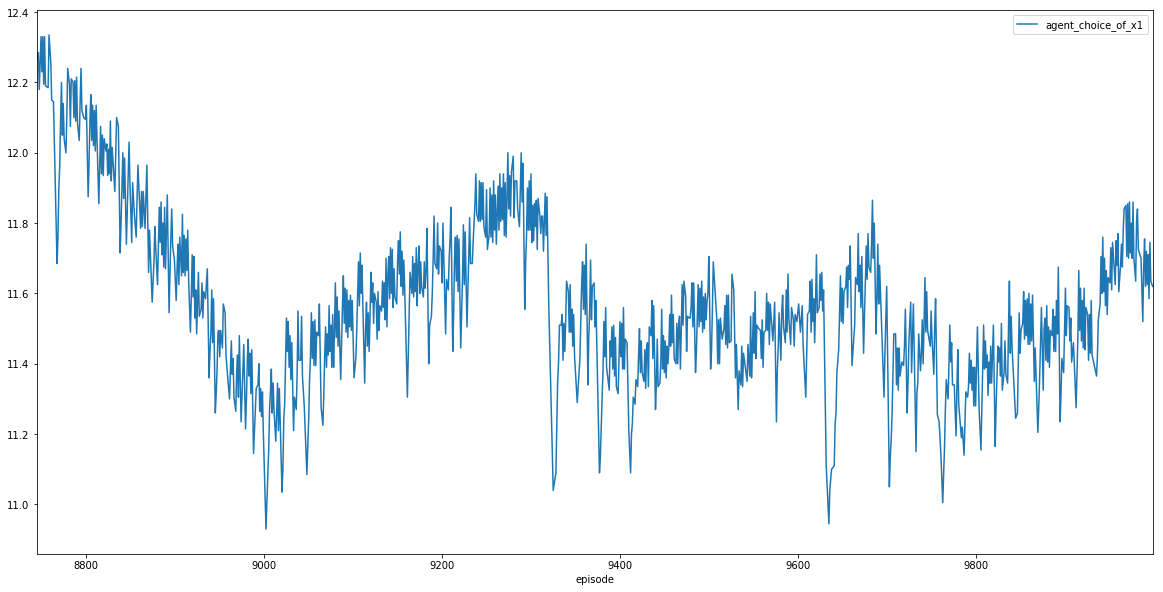

In [26]:
# Agent choice without greedy 

df_wo_greedy[-1000:].plot(x="episode", y="agent_choice_of_x1")

In [17]:
df_wo_greedy.head()


,agent_choice_of_x1,agent_final_cash_balance,cumulative_liquidity_costs,episode,greedy,initial_state,optimal_choice_of_x1,optimal_final_cash_balance
695,7.985000,15.263577,-0.380525,695,0,"[[5.0], [10.0], [1.0], [0.0]]",2.5,15.137178
730,7.995000,15.584774,-0.394682,730,0,"[[5.0], [10.0], [1.0], [0.0]]",2.5,15.240493
762,8.009999,11.730857,-0.240021,762,0,"[[5.0], [10.0], [1.0], [0.0]]",2.5,14.004319
837,8.035000,11.288065,-0.224425,837,0,"[[5.0], [10.0], [1.0], [0.0]]",2.5,13.866369
879,8.045000,14.619948,-0.361200,879,0,"[[5.0], [10.0], [1.0], [0.0]]",2.5,14.932232


In [18]:
df_wo_greedy.head()
print("Mean {} and Std {} of agent_final_cash_balance".format(np.mean(df_wo_greedy["agent_final_cash_balance"]), np.std(df_wo_greedy["agent_final_cash_balance"])))
print("Mean {} and Std {} of optimal_final_cash_balance".format(np.mean(df_wo_greedy["optimal_final_cash_balance"]), np.std(df_wo_greedy["optimal_final_cash_balance"])))

print("Mean {} and Std {} of agent_final_cash_balance from last 50 observations".format(np.mean(df_wo_greedy[-50:]["agent_final_cash_balance"]), np.std(df_wo_greedy[-1000:]["agent_final_cash_balance"])))
print("Mean {} and Std {} of optimal_final_cash_balance from last 50 observations".format(np.mean(df_wo_greedy[-50:]["optimal_final_cash_balance"]), np.std(df_wo_greedy[-1000:]["optimal_final_cash_balance"])))


Mean 13.948414827940848 and Std 3.419049216368146 of agent_final_cash_balance
Mean 14.943188572444646 and Std 0.7094066710345241 of optimal_final_cash_balance
Mean 13.886366233825683 and Std 3.1249678767251616 of agent_final_cash_balance from last 50 observations
Mean 14.887166686886353 and Std 0.7058758867330117 of optimal_final_cash_balance from last 50 observations


C:\Users\lukas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


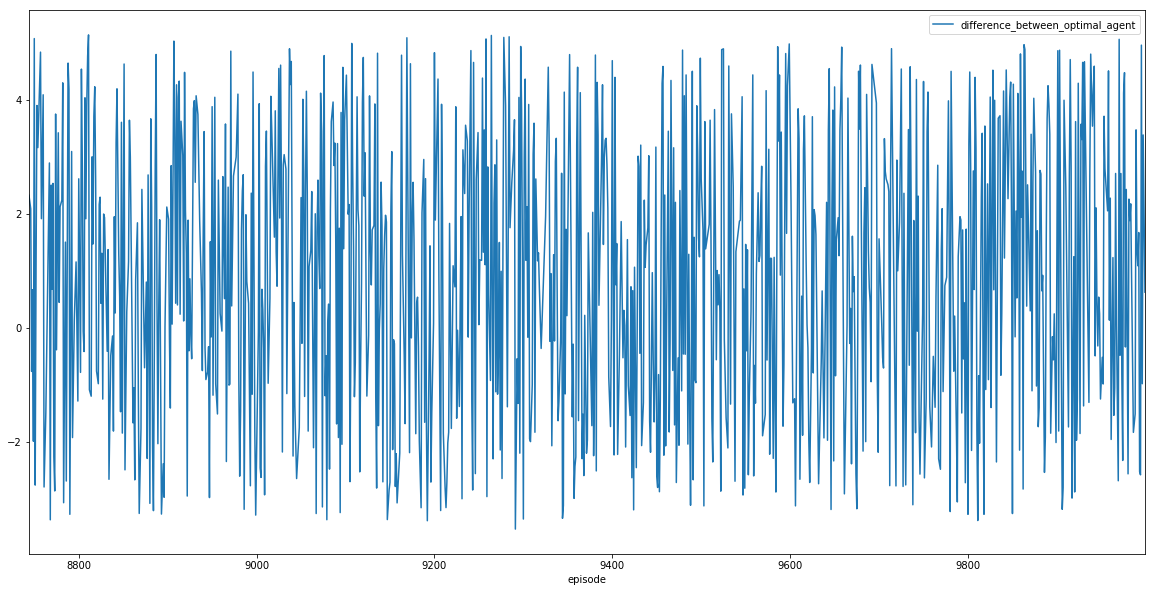

In [25]:
# Plot difference in cash
df_wo_greedy["difference_between_optimal_agent"] =df_wo_greedy["optimal_final_cash_balance"]-df_wo_greedy["agent_final_cash_balance"]

df_wo_greedy[-1000:].plot(x="episode", y="difference_between_optimal_agent")

In [20]:
df_wo_greedy["difference_between_optimal_agent"].mean()

0.9947737445037962

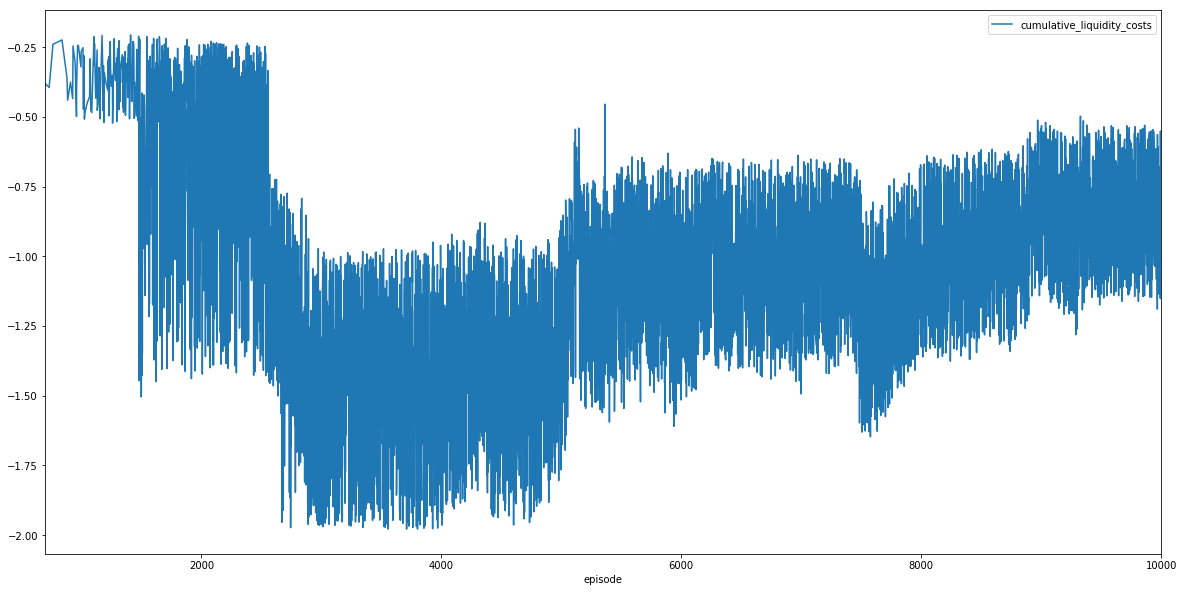

In [22]:
df_wo_greedy.plot(x="episode", y="cumulative_liquidity_costs")

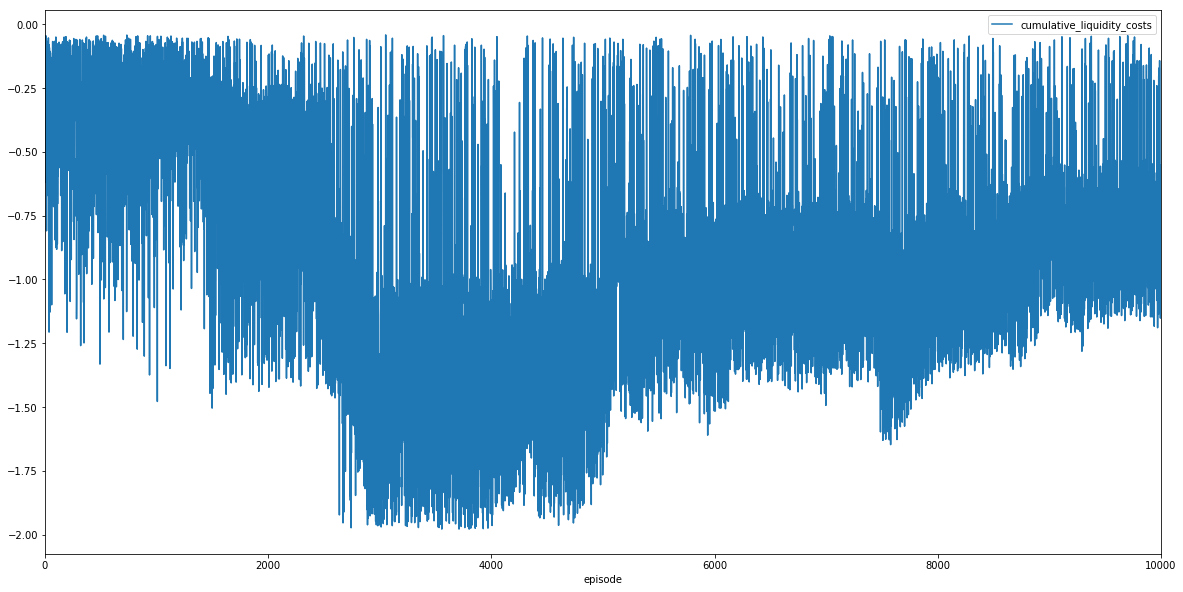

In [23]:
df.plot(x="episode", y="cumulative_liquidity_costs")